# Data description & Problem statement: 
This data set contains a total 5820 evaluation scores provided by students from Gazi University in Ankara (Turkey). There is a total of 28 course specific questions and additional 5 attributes. Please check the description at: http://archive.ics.uci.edu/ml/datasets/turkiye+student+evaluation

* Dataset is imbalanced. The data has 5820 rows and 33 variables.
* This is a classification problem. The classification goal is to predict number of times the student is taking this course: 0 (passed) and >0 (failed).

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial XGBoost model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of XGBoost model: Find the best XGBoost model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best XGBoost model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision
     
Finally, calculate the Feature Importance. 

In [1]:
import sklearn
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Turkiye student evaluation/turkiye-student-evaluation_generic.csv', sep=',') 


# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.head()

,instr,class,nb.repeat,attendance,difficulty,Q1,Q2,Q3,Q4,Q5,...,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28
0,1,10,1,1,4,4,4,3,3,3,...,2,4,3,3,3,3,2,2,1,1
1,2,11,1,1,4,1,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,3,8,2,1,3,3,3,3,3,3,...,3,3,3,3,2,3,3,3,3,4
3,3,13,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,2,6,1,3,2,3,3,4,4,4,...,2,2,3,3,2,2,3,3,4,3


In [3]:
df['nb.repeat']=df['nb.repeat'].map({1: 0, 2: 1, 3: 1})

In [4]:
#X=df.drop('nb.repeat', axis=1)
#X=df[['attendance', 'difficulty', 'class', 'instr', 'Q3', 'Q9', 'Q11',
#      'Q14', 'Q15', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22',
#      'Q25', 'Q26', 'Q28']]
X=df[['attendance', 'difficulty', 'class', 'instr']]
y=df['nb.repeat']

In [5]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

encode_text_dummy(X, 'instr')

In [6]:
# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Building the Initial Model & Cross-Validation: 
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=XGBClassifier() 
kfold=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.7607366  0.75196318 0.73303017 0.76652169] 

Accuracy: 0.75 (+/- 0.01)


In [8]:
# Grid-Search for the best model parameters: 

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

X_r, y_r=np.array(X_train), np.array(y_train)
#X_r, y_r = SMOTE(random_state=42, kind='svm').fit_sample(X_train, y_train)
#X_r, y_r = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)


# We create a sample_weight list for this imbalanced dataset:
from sklearn.utils.class_weight import compute_sample_weight
sw=compute_sample_weight(class_weight='balanced', y=y_r)


from sklearn.model_selection import GridSearchCV
param={'max_depth':[2, 3, 4, 5], 'min_child_weight':[1, 2, 3, 4], 'gamma': [ 0, 0.01, 0.05, 0.1]}

kfold=StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search=GridSearchCV(XGBClassifier(), param, cv=kfold, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_r, y_r, sample_weight=sw)
#grid_search.fit(X_r, y_r)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.095077,0.008840,0.006787,0.000868,0,2,1,"{'gamma': 0, 'max_depth': 2, 'min_child_weight...",0.752612,0.753,0.762539,0.75605,0.004591,1,0.774145,0.774582,0.773048,0.773925,0.000645
33,0.133677,0.006290,0.005905,0.001010,0.05,2,2,"{'gamma': 0.05, 'max_depth': 2, 'min_child_wei...",0.752612,0.753,0.762539,0.75605,0.004591,1,0.774145,0.774582,0.773048,0.773925,0.000645
32,0.141701,0.007865,0.006559,0.001355,0.05,2,1,"{'gamma': 0.05, 'max_depth': 2, 'min_child_wei...",0.752612,0.753,0.762539,0.75605,0.004591,1,0.774145,0.774582,0.773048,0.773925,0.000645


In [9]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(np.array(X_test), y_test),2))

Best parameters:  {'gamma': 0, 'max_depth': 2, 'min_child_weight': 1}
Best validation accuracy:  0.76 (+/- 0.00)
Test score:  0.78


Confusion matrix, without normalization
[[667 321]
 [ 44 132]]
Normalized confusion matrix
[[0.68 0.32]
 [0.25 0.75]]


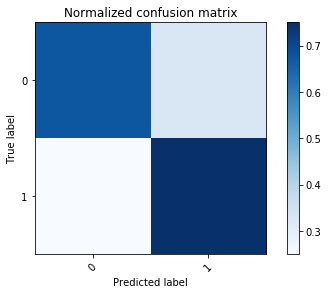

In [10]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

names = ["0", "1"]

# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(np.array(X_test)))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, names, title='Normalized confusion matrix')

plt.show()

In [11]:
# Classification report:
report=classification_report(y_test, grid_search.predict(np.array(X_test)))
print(report)

             precision    recall  f1-score   support

          0       0.94      0.68      0.79       988
          1       0.29      0.75      0.42       176

avg / total       0.84      0.69      0.73      1164



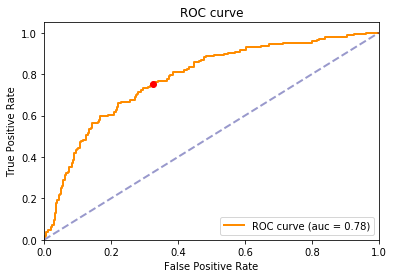

In [12]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(np.array(X_test))[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(np.array(X_test))[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

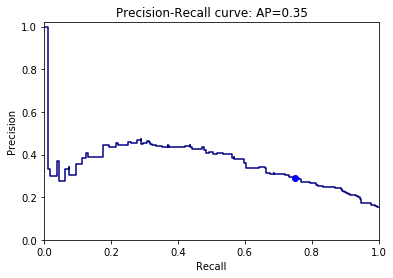

In [13]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(np.array(X_test))[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(np.array(X_test))[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()

('class', 0.3289855)
('attendance', 0.31304348)
('difficulty', 0.22753623)
('instr-3', 0.07971015)
('instr-1', 0.046376813)
('instr-2', 0.004347826)


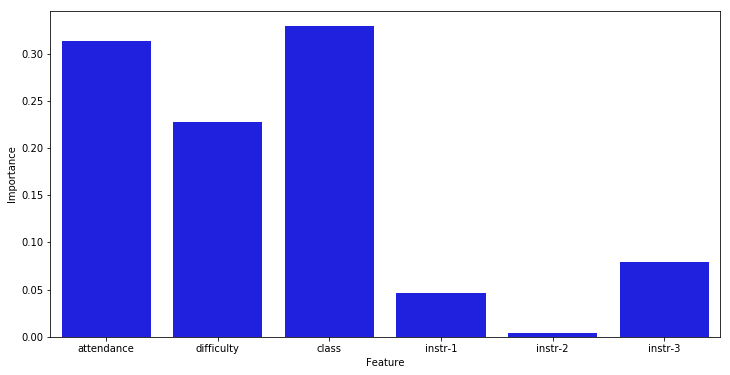

In [14]:
# Feature Importance:
im=XGBClassifier().fit(X,y).feature_importances_

# Sort & Plot:
d=dict(zip(np.array(X.columns), im))
k=sorted(d,key=lambda i: d[i], reverse= True)
[print((i,d[i])) for i in k]

# Plot:
c1=pd.DataFrame(np.array(im),  columns=["Importance"])
c2=pd.DataFrame(np.array(X.columns),columns=["Feature"])

fig, ax = plt.subplots(figsize=(12,6)) 
sns.barplot(x="Feature", y="Importance", data=pd.concat([c2,c1], axis=1), color="blue", ax=ax)

plt.show()